In [465]:
#Import Libraries

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [466]:
#Downloading data

ticker = 'SPY'
start = '1999-03-10'  # Start date
end = '2024-05-20'  # End date

data = yf.download(ticker, start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


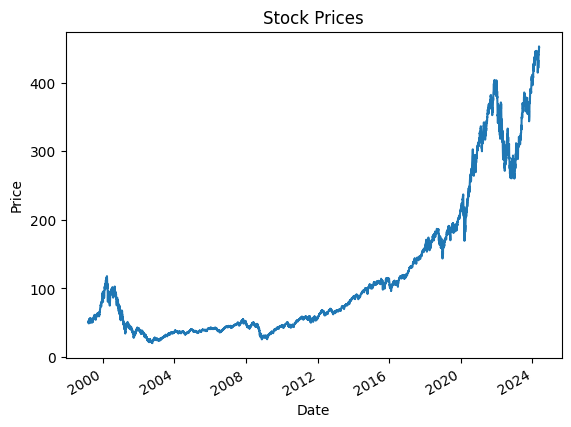

In [467]:
# Fetch intraday data at 1-day intervals and create line plot to visualize pricing

data['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Stock Prices")
plt.show()

In [468]:
#Calculating all necessary features for backtesting

# Calculate necessary variables with shifted data
data['yesterday_Close'] = data['Adj Close'].shift(1)
data['two_days_ago_Close'] = data['Adj Close'].shift(2)
data['three_days_ago_Close'] = data['Adj Close'].shift(3)
data['yesterday_High'] = data['High'].shift(1)

# Drop rows with NaN values resulting from shifting
data.dropna(inplace=True)

data['mondaydecrease'] = data['Adj Close'] - data['yesterday_Close']
data['fridaydecrease'] = data['two_days_ago_Close'] - data['three_days_ago_Close']


def relative_strength_index(data, period=14):
    # Calculate the daily price changes
    deltas = data.diff()

    # Separate gains and losses
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)

    # Calculate the exponential moving average of gains and losses
    avg_gains = gains.ewm(span=period, min_periods=period).mean()
    avg_losses = losses.ewm(span=period, min_periods=period).mean()

    # Calculate the relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Apply thresholds
    rsi_signal = pd.Series(0, index=data.index)  # Initialize with 0
    rsi_signal[rsi < 30] = 1
    rsi_signal[rsi > 70] = -1

    return rsi, rsi_signal

data['rsi'], data['rsi_signal'] = relative_strength_index(data['Adj Close'])

# Add the day of the week as a new column
data['day_of_week'] = data.index.day_name()
# Define a dictionary to map day names to numbers
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 1,
    'Thursday': 0,
    'Friday': 0,
    'Saturday': 0,
    'Sunday': 0
}

# Apply the mapping to the 'day_of_week' column
data['day_of_week_num'] = data['day_of_week'].map(day_mapping)

#Answer
data['tommorrows_close'] = data['Adj Close'].shift(-1)
data['answer'] = (data['tommorrows_close'] > data['Adj Close']) & (data['day_of_week_num'] == 1)
data['answer'] = data['answer'].astype(int)

data.dropna(inplace=True)

print(data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-10  442.540009  444.309998  440.500000  442.059998  441.358490   
2024-05-13  443.989990  444.089996  441.649994  443.079987  442.376862   
2024-05-14  442.649994  446.470001  442.459991  445.929993  445.222351   
2024-05-15  448.429993  453.149994  446.899994  452.899994  452.181274   
2024-05-16  452.709991  454.690002  451.809998  451.980011  451.262756   

              Volume  yesterday_Close  two_days_ago_Close  \
Date                                                        
2024-05-10  27116600       440.320129          439.361664   
2024-05-13  22994200       441.358490          440.320129   
2024-05-14  34478300       442.376862          441.358490   
2024-05-15  41464700       445.222351          442.376862   
2024-05-16  34780400       452.181274          445.222351   

            three_days_ago_Close  yesterday_High  mon

In [469]:
#Adding more features

data['IBS'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
# Create binary signals
data['RSI_overbought'] = (data['rsi'] > 70).astype(int)
data['RSI_oversold'] = (data['rsi'] < 30).astype(int)
data['IBS_high'] = (data['IBS'] > 0.8).astype(int)
data['IBS_low'] = (data['IBS'] < 0.2).astype(int)
data['mondaydecrease-bool'] = (((data['Adj Close'] - data['yesterday_Close'])/ data['yesterday_Close']) < -0.02).astype(int)
data['fridaydecrease-bool'] = (((data['two_days_ago_Close'] - data['three_days_ago_Close']) / data['three_days_ago_Close']) < -0.02).astype(int)


#Implementing logistic regression from scratch

In [470]:
features = ['mondaydecrease', 'fridaydecrease', 'day_of_week_num', 'IBS_low', 'RSI_oversold']
target = 'answer'

X = data[features]
y = data[target]

#Normalize data using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [471]:
#Predicting functions

#Initialize parameters
W = np.random.randn(len(features))
b = 0

#Sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

#predict function
def predict(X, W, b):
  z = np.dot(X, W) + b

  return sigmoid(z)

#calculate accuracy
def accuracy(X, y_true, W, b):
  y_pred = predict(X, W, b)
  tot_pred = 0
  correct_pred = 0
  for i in range(len(y_pred)):
    output = (y_pred[i] > 0.5)
    if output:
      tot_pred += 1
      if y_true[i] == 1:
        correct_pred += 1
  if tot_pred == 0:
    return 0
  accuracy = (correct_pred / tot_pred) * 100

  print(f"total predictions = {tot_pred}")
  return accuracy

def cross_entropy_loss(y_pred, y_true):
    # Avoiding division by zero
    epsilon = 1e-15
    # Clip y_pred between epsilon and 1-epsilon to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    # Compute cross-entropy loss
    ce_loss = -np.mean(y_true * np.log(y_pred) + (1. - y_true) * np.log(1. - y_pred))
    return ce_loss

#Cost function
def cost_function(X, y, W, b):
  m = len(y)
  predictions = predict(X, W, b)
  cost = cross_entropy_loss(predictions, y)
  return cost

#Compute gradient
def compute_gradient(X, y, W, b, iteration, beta1=0.9, beta2=0.999, dW_rmsprop=np.zeros(len(W)), db_rmsprop=0, dW_momentum=np.zeros(len(W)), db_momentum=0):
  m = len(y)
  predictions = predict(X, W, b)
  dW = (1 / m) * np.dot(X.T, (predictions - y))
  db = (1 / m) * np.sum(predictions - y)

  #Calculating momentum
  dW_momentum = beta1 * dW_momentum + (1 - beta1) * dW
  db_momentum = beta1 * db_momentum + (1 - beta1) * db

  #Calculating rmsprop
  dW_rmsprop = beta2 * dW_rmsprop + (1 - beta2) * dW ** 2
  db_rmsprop = beta2 * db_rmsprop + (1 - beta2) * db ** 2

  #Bias correction
  dW_momentum = dW_momentum / (1 - beta1 ** iteration)
  db_momentum = db_momentum / (1 - beta1 ** iteration)
  dW_rmsprop = dW_rmsprop / (1 - beta2 ** iteration)
  db_rmsprop = db_rmsprop / (1 - beta2 ** iteration)

  #Combining rmsprop and momentum
  epsilon = 1e-8 #Very small value to prevent from dividing by 0

  dW_corrected = dW_momentum / np.sqrt(dW_rmsprop + epsilon)
  db_corrected = db_momentum / np.sqrt(db_rmsprop + epsilon)

  return dW_corrected, db_corrected

#Gradient descent
def gradient_descent(X, y, W, b, learning_rate, num_iterations):
  traincost_history = []
  valcost_history = []
  trainaccuracy_history = []
  valaccuracy_history = []

  for i in range(1, num_iterations+1):
    dW, db = compute_gradient(X_train, y_train, W, b, i)
    W = W - (learning_rate * dW)
    b = b - (learning_rate * db)
    train_cost = cost_function(X_train, y_train, W, b)

    trainaccuracy = accuracy(X_train, y_train, W, b)
    trainaccuracy_history.append(trainaccuracy)

    val_cost = cost_function(X_test, y_test, W, b)
    valaccuracy = accuracy(X_test, y_test, W, b)
    valaccuracy_history.append(valaccuracy)
    print(f"Iteration {i}: Training Cost = {train_cost}, Training Accuracy = {trainaccuracy}")
    print(f"Iteration {i}: Validation Cost = {val_cost}, Validation Accuracy = {valaccuracy}")

    traincost_history.append(train_cost)
    valcost_history.append(val_cost)

  return W, b, traincost_history, valcost_history, trainaccuracy_history, valaccuracy_history



In [472]:
#Training linear regression model
W, b, traincost_history, valcost_history, trainaccuracy_history, valaccuracy_history  = gradient_descent(X_train, y_train, W, b, learning_rate=0.01, num_iterations=300)

total predictions = 34
total predictions = 11
Iteration 1: Training Cost = 0.8072172157274087, Training Accuracy = 0.0
Iteration 1: Validation Cost = 0.8257039178838431, Validation Accuracy = 0.0
total predictions = 36
total predictions = 11
Iteration 2: Training Cost = 0.8056757393065137, Training Accuracy = 0.0
Iteration 2: Validation Cost = 0.8240568172677247, Validation Accuracy = 0.0
total predictions = 32
total predictions = 10
Iteration 3: Training Cost = 0.8043415525811026, Training Accuracy = 0.0
Iteration 3: Validation Cost = 0.8227306094442808, Validation Accuracy = 0.0
total predictions = 32
total predictions = 10
Iteration 4: Training Cost = 0.8031369391883502, Training Accuracy = 0.0
Iteration 4: Validation Cost = 0.8214572141871029, Validation Accuracy = 0.0
total predictions = 28
total predictions = 10
Iteration 5: Training Cost = 0.8020040680751397, Training Accuracy = 0.0
Iteration 5: Validation Cost = 0.8203212006309729, Validation Accuracy = 0.0
total predictions = 

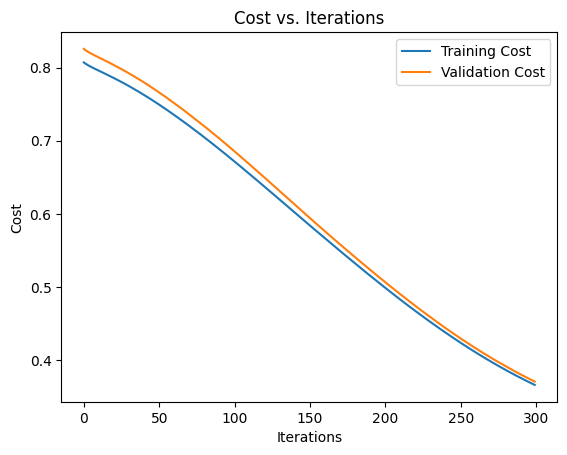

In [473]:
plt.plot(traincost_history, label='Training Cost')
plt.plot(valcost_history, label='Validation Cost')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

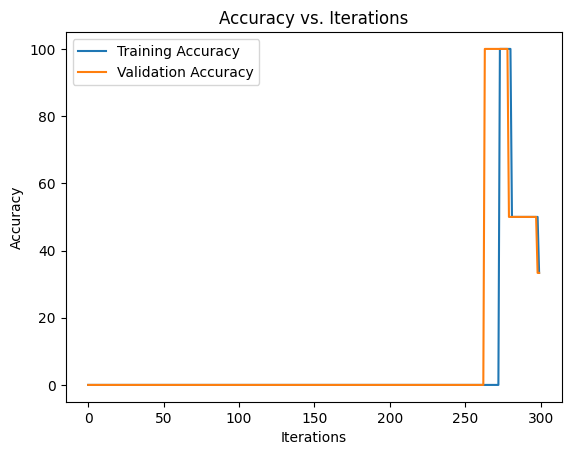

In [474]:
plt.plot(trainaccuracy_history, label='Training Accuracy')
plt.plot(valaccuracy_history, label='Validation Accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations')
plt.show

#Backtesting

In [475]:
THRESHOLD = 0.5
entry_condition = predict(X, W, b) > THRESHOLD

# Initialize variables for tracking trades and performance
initial_capital = 100000.0
account_balance = initial_capital
trades = []
annual_returns = [initial_capital]
equity_curve = [initial_capital] # Start with initial capital
equity_dates = [data.index[0]]
in_trade = False
last_save = 0

for i in range(len(data)):
    if entry_condition[i] and not in_trade:
        entry_price = data['Adj Close'].iloc[i] # Access data using .iloc with numerical index
        shares = account_balance / entry_price
        in_trade = True

    elif in_trade:
        exit_price = data['Adj Close'].iloc[i] # Access data using .iloc with numerical index
        profits = shares * (exit_price - entry_price)
        account_balance += profits
        trades.append([entry_price, exit_price, shares, profits])
        equity_curve.append(account_balance)
        equity_dates.append(data.index[i]) # Access data index using numerical index
        in_trade = False
        if(i - last_save >= 365):
          annual_returns.append(account_balance)
          last_save = i



Final account balance: 653116.8128920372
Equity curve:  [100000.0, 96571.45750166937, 92041.92518701772, 96584.35321111466, 93280.01589269064, 93880.79808033786, 96725.69328671176, 98114.90406112125, 99662.25242574135, 101043.27641901524, 100111.3914781566, 96833.0232150404, 96744.41155071223, 98378.6534549888, 101392.67923139675, 103088.6470470924, 101526.1646835436, 103040.55695559035, 104665.2239866673, 104530.78728990616, 106142.46841723123, 106312.94274029305, 108121.26293754017, 108641.91654503462, 108805.17981661293, 110995.87624918603, 108623.45620118821, 107916.8048645661, 109632.017051647, 108223.31315730387, 111784.89181179013, 116653.37047205784, 115264.6462275485, 116546.07387660375, 116137.14028405427, 114566.14718764163, 114507.9431863704, 115721.20873511439, 115871.91206571479, 116410.58703204899, 117632.10250995836, 120272.56981585073, 122682.25124533226, 119041.83313480963, 117535.17134909212, 121119.33120406915, 120934.70492331412, 122520.98021931855, 126277.50426972

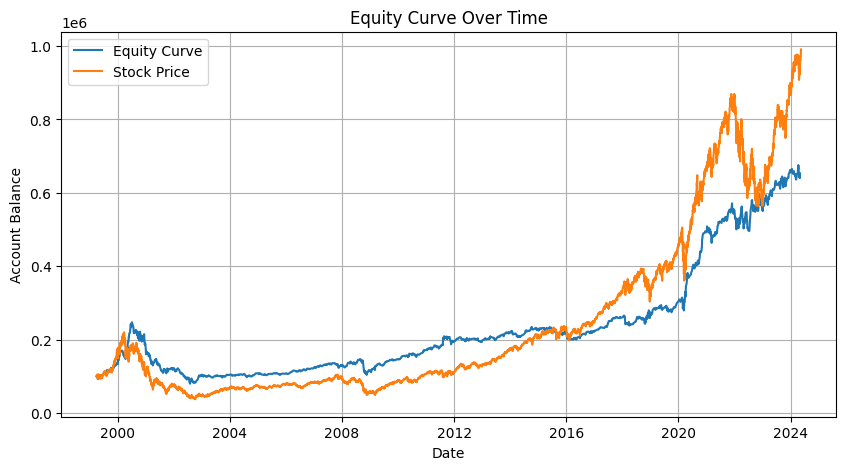

In [476]:
# If you want to print the results
print(f"Final account balance: {account_balance}")
print("Equity curve: ", equity_curve)
print("Trades: ", trades)


# Calculate the average monthly return
percent_returns =[]
for i in range(1, len(annual_returns)):
    percent_returns.append((annual_returns[i] - annual_returns[i-1]) / annual_returns[i-1])

print("Percent returns: ", percent_returns)
print(f"Average annual return: {np.mean(percent_returns) * 100:.2f}%")
print("Exposure percent: " , len(trades)/ len(data))

#Calculate sharpe ratio
sharpe_ratio = np.mean(percent_returns) / np.std(percent_returns)
print(f"Sharpe ratio: {sharpe_ratio}")

# Plot the equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity_dates, equity_curve, label='Equity Curve')
shares = 100000.0/data['Adj Close'].iloc[0]
plt.plot(data.index, data['Adj Close'] * shares, label='Stock Price')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.title('Equity Curve Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [477]:
def calculate_max_drawdown(equity_curve):
    max_drawdown = 0.0
    peak = equity_curve[0]
    trough = equity_curve[0]

    for i in range(1, len(equity_curve)):
        if equity_curve[i] > peak:
            peak = equity_curve[i]
            trough = peak
        elif equity_curve[i] < trough:
            trough = equity_curve[i]

        drawdown = (peak - trough) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    return max_drawdown

max_drawdown = calculate_max_drawdown(equity_curve)
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

Max Drawdown: 67.76%
